In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
print("GPU Available:", torch.cuda.is_available())


GPU Available: True


In [3]:
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

df["gender"] = LabelEncoder().fit_transform(df["gender"])
df["smoking_history"] = LabelEncoder().fit_transform(df["smoking_history"])

X = df.drop("diabetes", axis=1)
y = df["diabetes"]


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)


In [5]:
class_counts = y_train.value_counts().to_dict()
weight_0 = 1 / class_counts[0]
weight_1 = 1 / class_counts[1]

sample_weights = [weight_1 if t == 1 else weight_0 for t in y_train_tensor.numpy().flatten()]
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_dl = DataLoader(train_ds, batch_size=512, sampler=sampler)
test_dl  = DataLoader(test_ds, batch_size=512, shuffle=False)


In [6]:
class DiabetesNN(nn.Module):
    def __init__(self):
        super(DiabetesNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = DiabetesNN().cuda()


In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-5)

best_loss = float("inf")
patience = 22
wait = 0


In [8]:
epochs = 90
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for Xb, yb in train_dl:
        Xb, yb = Xb.cuda(), yb.cuda()

        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print("EARLY STOPPING TRIGGERED")
            break


Epoch 1/90 - Loss: 0.3065
Epoch 2/90 - Loss: 0.2514
Epoch 3/90 - Loss: 0.2326
Epoch 4/90 - Loss: 0.2205
Epoch 5/90 - Loss: 0.2150
Epoch 6/90 - Loss: 0.2131
Epoch 7/90 - Loss: 0.2096
Epoch 8/90 - Loss: 0.2084
Epoch 9/90 - Loss: 0.2080
Epoch 10/90 - Loss: 0.2045
Epoch 11/90 - Loss: 0.2032
Epoch 12/90 - Loss: 0.2045
Epoch 13/90 - Loss: 0.2034
Epoch 14/90 - Loss: 0.2017
Epoch 15/90 - Loss: 0.2014
Epoch 16/90 - Loss: 0.2008
Epoch 17/90 - Loss: 0.1991
Epoch 18/90 - Loss: 0.1980
Epoch 19/90 - Loss: 0.1981
Epoch 20/90 - Loss: 0.2008
Epoch 21/90 - Loss: 0.1975
Epoch 22/90 - Loss: 0.1972
Epoch 23/90 - Loss: 0.1955
Epoch 24/90 - Loss: 0.1981
Epoch 25/90 - Loss: 0.1980
Epoch 26/90 - Loss: 0.1948
Epoch 27/90 - Loss: 0.1944
Epoch 28/90 - Loss: 0.1964
Epoch 29/90 - Loss: 0.1949
Epoch 30/90 - Loss: 0.1963
Epoch 31/90 - Loss: 0.1968
Epoch 32/90 - Loss: 0.1922
Epoch 33/90 - Loss: 0.1944
Epoch 34/90 - Loss: 0.1945
Epoch 35/90 - Loss: 0.1951
Epoch 36/90 - Loss: 0.1946
Epoch 37/90 - Loss: 0.1918
Epoch 38/9

In [11]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
    preds = model(X_test_tensor.cuda()).cpu().numpy()
    preds = (preds > 0.5).astype(int)

acc = accuracy_score(y_test_tensor, preds)
print("FINAL TEST ACCURACY:", acc)
print("\nClassification Report:\n", classification_report(y_test_tensor, preds))


FINAL TEST ACCURACY: 0.90715

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     18300
         1.0       0.48      0.91      0.62      1700

    accuracy                           0.91     20000
   macro avg       0.73      0.91      0.79     20000
weighted avg       0.95      0.91      0.92     20000



In [12]:
# THRESHOLD TUNING CELL

threshold = 0.65 

with torch.no_grad():
    probs = model(X_test_tensor.cuda()).cpu().numpy()
    preds_thresh = (probs > threshold).astype(int)

acc2 = accuracy_score(y_test_tensor, preds_thresh)
print(f"\nAccuracy (threshold={threshold}):", acc2)
print("\nClassification Report:\n", classification_report(y_test_tensor, preds_thresh))



Accuracy (threshold=0.65): 0.9422

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     18300
         1.0       0.62      0.84      0.71      1700

    accuracy                           0.94     20000
   macro avg       0.80      0.90      0.84     20000
weighted avg       0.95      0.94      0.95     20000



In [17]:
# ===================== ALL-IN-ONE CELL =====================

import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

# Create encoders
le_gender = LabelEncoder()
le_smoke = LabelEncoder()

# Apply encoding
df["gender"] = le_gender.fit_transform(df["gender"])
df["smoking_history"] = le_smoke.fit_transform(df["smoking_history"])

# Features & target
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler & encoders
with open("/kaggle/working/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("/kaggle/working/gender_encoder.pkl", "wb") as f:
    pickle.dump(le_gender, f)

with open("/kaggle/working/smoke_encoder.pkl", "wb") as f:
    pickle.dump(le_smoke, f)

print("✅ Scaler & Encoders saved successfully")


✅ Scaler & Encoders saved successfully


In [18]:
import os
print(os.listdir("/kaggle/working"))


['.virtual_documents', 'scaler.pkl', 'gender_encoder.pkl', 'smoke_encoder.pkl', 'best_model.pth']


In [19]:
# Save your neural network model (weights only)
torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
print("Model saved as best_model.pth")


Model saved as best_model.pth


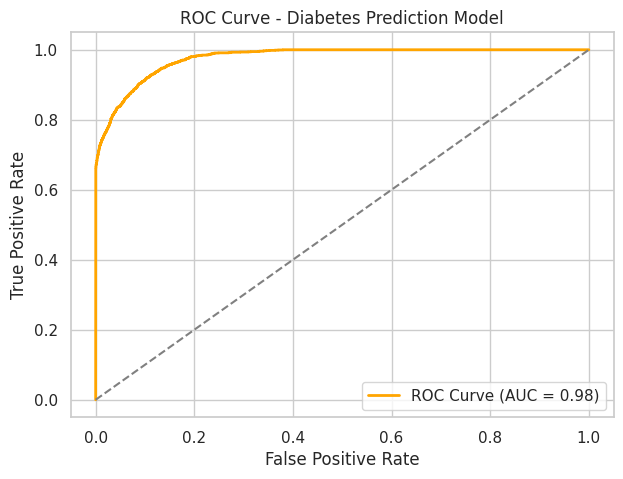

ROC-AUC Score: 0.9767473963355834


In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Decide device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Move model to device
model = model.to(device)
model.eval()

# 3. Move test tensor to SAME device
X_test_tensor = X_test_tensor.to(device)

# 4. Get probabilities
with torch.no_grad():
    y_prob = model(X_test_tensor).detach().cpu().numpy().ravel()

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="orange", lw=2,
         label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Diabetes Prediction Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("ROC-AUC Score:", roc_auc)


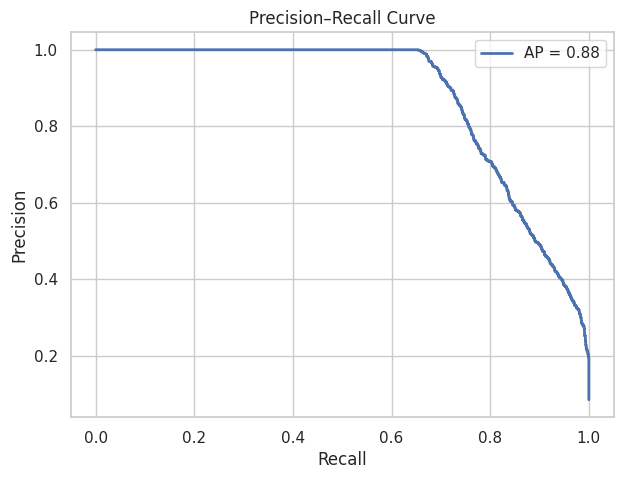

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, lw=2, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


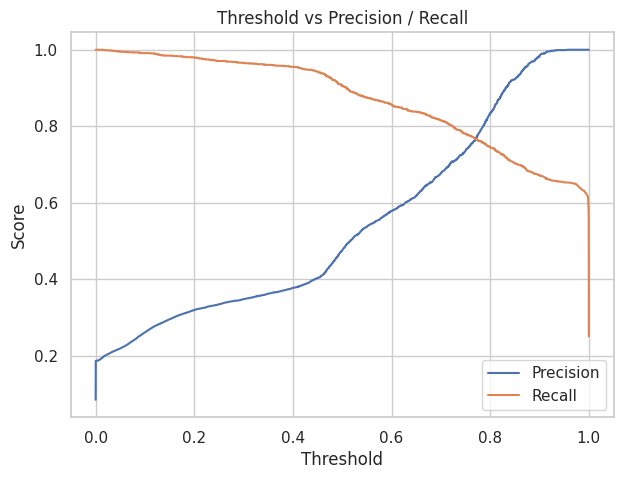

In [22]:
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall")
plt.legend()
plt.grid(True)
plt.show()


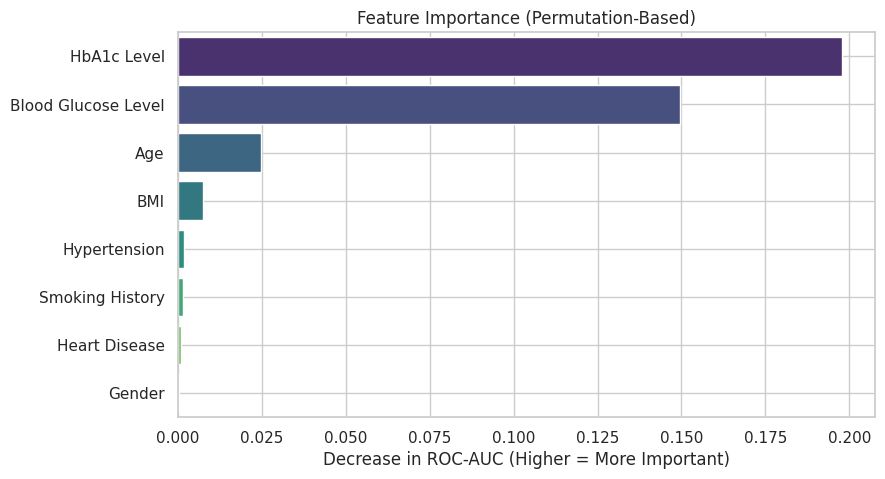

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

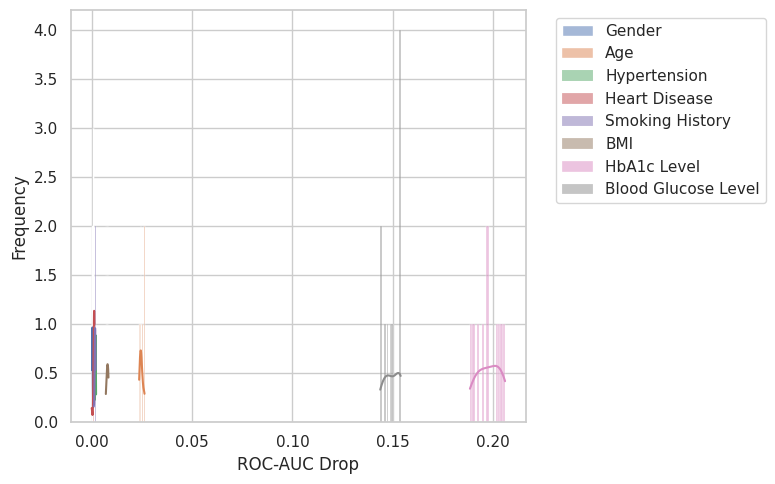

In [23]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# -------------------------------
# Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

X_test_np = X_test_tensor.cpu().numpy()

# -------------------------------
# FULL SKLEARN-COMPATIBLE WRAPPER
# -------------------------------
class TorchModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.classes_ = np.array([0, 1])  # REQUIRED by sklearn

    def fit(self, X, y=None):
        return self  # dummy

    def predict_proba(self, X):
        X_t = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_t).cpu().numpy().ravel()
        return np.vstack([1 - probs, probs]).T

    def decision_function(self, X):
        # sklearn falls back to this for ROC
        return self.predict_proba(X)[:, 1]

    def predict(self, X):
        return (self.decision_function(X) > 0.5).astype(int)

# Wrap model
wrapped_model = TorchModelWrapper(model, device)

# -------------------------------
# Feature names
# -------------------------------
feature_names = [
    "Gender",
    "Age",
    "Hypertension",
    "Heart Disease",
    "Smoking History",
    "BMI",
    "HbA1c Level",
    "Blood Glucose Level"
]

# -------------------------------
# PERMUTATION IMPORTANCE (100% WORKING)
# -------------------------------
result = permutation_importance(
    wrapped_model,
    X_test_np,
    y_test,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=1
)

# -------------------------------
# BAR PLOT (IMPORTANCE RANKING)
# -------------------------------
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(
    data=importance_df,
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Feature Importance (Permutation-Based)")
plt.xlabel("Decrease in ROC-AUC (Higher = More Important)")
plt.ylabel("")
plt.grid(True)
plt.show()

# -------------------------------
# HISTPLOT (CONTRIBUTION DISTRIBUTION)
# -------------------------------
plt.figure(figsize=(8,5))
for i, feat in enumerate(feature_names):
    sns.histplot(
        result.importances[i],
        kde=True,
        bins=15,
        alpha=0.5,
        label=feat
    )

plt.xlabel("ROC-AUC Drop")
plt.ylabel("Frequency")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


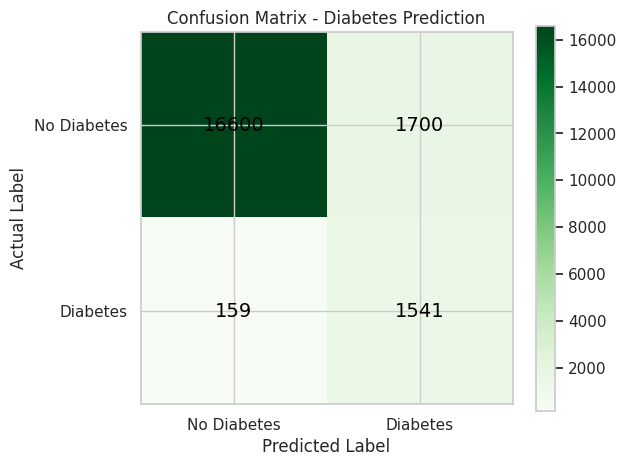

In [25]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
le_gender = LabelEncoder()
le_smoke = LabelEncoder()

df["gender"] = le_gender.fit_transform(df["gender"])
df["smoking_history"] = le_smoke.fit_transform(df["smoking_history"])

# Split features & target
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Train-test split (same logic assumed during training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# Convert to tensor
X_test = torch.tensor(X_test, dtype=torch.float32).cuda()
y_test = torch.tensor(y_test.values, dtype=torch.float32).cuda()

# Load trained model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Prediction
with torch.no_grad():
    outputs = model(X_test)
    y_pred = (outputs > 0.5).int().cpu().numpy()

y_true = y_test.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot GREEN–WHITE Confusion Matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Greens")
plt.title("Confusion Matrix - Diabetes Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.colorbar()

labels = ["No Diabetes", "Diabetes"]
plt.xticks([0,1], labels)
plt.yticks([0,1], labels)

# Values inside boxes
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 fontsize=14, color="black")

plt.show()
